# Breakout - Policy Gradient Method
## Policy Gradients Vanilla type
* Borrowed heavily from structure of: [Vanilla Policy Gradient](https://github.com/awjuliani/DeepRL-Agents/blob/master/Vanilla-Policy.ipynb)
* In order to determine positive and negative rewards we must associate it with some direction of the pole

In [1]:
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, convolutional, pooling, Flatten, Dropout, Input, BatchNormalization
from keras.optimizers import Adam
from keras import backend as Bk
from scipy.misc import imread, imshow
import math
import numpy as np
import matplotlib.pyplot as plt
import gym
%matplotlib inline

Using TensorFlow backend.


In [2]:
env = gym.make('Breakout-v0')
print(env.observation_space)  # 210v x 160w x 3color Box (sparse tensor!!!)
print(env.action_space)       # 6x1 Discrete
s = env.reset()
print(s.shape)
gamma = 0.99
try: 
    xrange(1)
except:
    xrange = range

[2017-05-18 20:41:14,721] Making new env: Breakout-v0


Box(210, 160, 3)
Discrete(6)
(210, 160, 3)


In [26]:
class rl_agent():
    def __init__(self,  
                 environment, 
                 state_space_size, 
                 action_space_size,               
                 hidden_units = 512,
                 learning_rate = 1e-4,             # Lambda or other for gradient descent
                 epsilon = 1e-8,                  # Error - error for types of gradient descent or random choice
                 random_choice_threshold = -1.22,
                 optimizer = Adam,
                 dropout_rate = 0.6,
                 load_file_weights = None,
                 verbose = 0,
                 frames = 3
                ):
        self.environment = environment
        self.hidden_units = hidden_units # hidden neurons
        self.state_space_size = state_space_size
        self.action_space_size = action_space_size
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.optimizer = optimizer
        self.dropout_rate = dropout_rate
        self.load_file_weights = load_file_weights
        self.verbose = verbose
        self.frames = frames
        self.input_dim = 6400
        self.prev_processed_state = None
        self.past_differences = []
        self.render = False
        self.random_choice_threshold = random_choice_threshold
        
    def define_model(self):
        # Keras vars
        self.model = Sequential()
        # Default is channels last
        self.model.add(convolutional.Conv2D(filters=64, kernel_size = (3,3), strides=(2,2), padding='valid', input_shape = (80,80, 1)))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        print(self.model.layers[-1].input_shape)
        print(self.model.layers[-1].output_shape)
        self.model.add(convolutional.Conv2D(filters=32, kernel_size = (3,3), strides=(2, 2), padding='same'))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        self.model.add(convolutional.Conv2D(filters=64, kernel_size = (3,3), strides=(2, 2), padding='valid'))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        self.model.add(convolutional.Conv2D(filters=64, kernel_size = (3,3), strides=(1, 1), padding='valid'))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        print(self.model.layers[-1].input_shape)
        print(self.model.layers[-1].output_shape)
        self.model.add(Flatten())
        self.model.add(Dense(self.hidden_units))   # Karpathy suggested N=200 in the hidden layer
        self.model.add(Dropout(self.dropout_rate))      # But since we are doing dropout to avoid overfitting... increase
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        self.model.add(Dense(self.hidden_units))   # Karpathy suggested N=200 in the hidden layer
        self.model.add(Dropout(self.dropout_rate))      # But since we are doing dropout to avoid overfitting... increase
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        print(self.model.layers[-1].input_shape)
        print(self.model.layers[-1].output_shape)
        self.model.add(Dense(6, activation='softmax'))  # Actions are a 6x1 vector
        optimizer = self.optimizer(lr=self.learning_rate, beta_1=0.9, beta_2=0.999, epsilon = self.epsilon, decay=0.0)
        self.model.compile(
            optimizer = optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        try:
             self.model.load_weights('saved_weights5.h5')
        except:
            print("Training model without old weights")
            
        # State space size will be a 210x160x1 dim
        self.state = Input(shape=[80,80,1])
        #  self.current_action = tf.argmax(self.output_layer,1)
        self.reward_tensor = Input(shape=(1,), dtype='float32')
        self.action_tensor = Input(shape=(1,), dtype='int32')
        
        if self.verbose >= 1:
            print(self.model.summary())
        
    def training(self, max_games = 100000):
        mean_rewards_list = []
        self.state = self.environment.reset()
        chosen_vectors, rewards, rewards_history = [], [], []
        running_reward = 0
        reward_for_episode = 0
        i = 0
        while True:
            history_element, done = self.choose_action()
            chosen_vectors.append(history_element[4]) # dlogps
            reward_for_episode += float(history_element[3]) 
            rewards.append(history_element[3]) # drs
            rewards_history.append(history_element[3]) 
            if done:
                i += 1
                all_episode_features = np.vstack(agent.past_differences) # epx
                plt.imshow(agent.state)
                all_episode_chosen_vectors = np.vstack(chosen_vectors) #epdlogp
                all_episode_rewards = np.vstack(rewards) # epr
                discounted_episode_rewards = apply_gamma(all_episode_rewards)
                # Standard normal feature scaling 
                std_dev = np.std(discounted_episode_rewards)+self.epsilon
                discounted_episode_rewards -= np.mean(discounted_episode_rewards)
                discounted_episode_rewards /= std_dev
                all_episode_chosen_vectors *= discounted_episode_rewards
                self.model.fit(all_episode_features.reshape([-1,80,80,1]), all_episode_chosen_vectors, epochs=1, verbose=0)
                self.prev_processed_state = None
                reward_for_episode = 0
                self.state = self.environment.reset()
                self.past_differences = []
                chosen_vectors = []
                rewards = []
                if i % 50 == 0 and i != 0:
                    print(len(rewards_history))
                    mean_rewards = np.mean(rewards_history[-50:])
                    self.saveweights()
                    self.savemodel()
                    mean_rewards_list.append(mean_rewards)
                    print("MEAN REWARDS:" + str(mean_rewards))
                    
    def savemodel(self):
        with open('saved_model5.json', 'w') as modelfile:
            modelfile.write(self.model.to_json())
            
    def saveweights(self):
        self.model.save_weights('saved_weights5.h5', overwrite=True)
        
    def choose_action(self):
        #Probabilistically pick an action given our network outputs.
        s = self.preprocess(self.state)
        self.state = s
        self.prev_processed_state = self.prev_processed_state if self.prev_processed_state is not None else np.zeros((1, 80,80, 1), dtype='float32')
        difference_processed = (s - self.prev_processed_state)
        self.prev_processed_state = s
        # difference_processed = difference_processed.flatten()
        self.past_differences.append(difference_processed)
        self.action_probabilities = self.model.predict(difference_processed.reshape([-1,80,80,1]), batch_size=1).flatten()
        e = np.random.normal()
        if (e < self.random_choice_threshold):
            action = np.random.choice(self.environment.action_space.n, 1)[0]
        else:
            action = np.random.choice(self.environment.action_space.n, 1,p=self.action_probabilities/np.sum(self.action_probabilities))[0]
        self.state, reward, done, info = self.environment.step(action)
        if self.render: self.environment.render()
        chosen_vector = np.zeros([self.environment.action_space.n])
        chosen_vector[action] = 1
        return [s,action, self.state, reward, chosen_vector], done
    
    def preprocess(self, state):
        # take a 210x160x3 image and convert to 210x160x1 as 210*160 length vector flattened F = float32 in dim
        # From https://docs.scipy.org/doc/scipy/reference/generated/scipy.misc.imread.html
        #r, g, b = state[:, :, 0], state[:, :, 1], state[:, :, 2]
        #F = r * 299.0/1000 + g * 587.0/1000 + b * 114.0/1000
        # Now using carpathy 0/1 conversion of a majority of the surface area of the screen down to 80x80
        F = state
        F = F[33:193] # crop vertical rows to 160
        F = F[::2,::2,0] # downsample by factor of 2 to 90x80 just keeps the first index of the 3rd dim
        F[F != 0] = 1 # everything else (paddles, ball) just set to 1
        F[F != 1] = 0
        return F.reshape([1,80,80,1])

In [27]:
def apply_gamma(r):
    discounted_r = np.zeros_like(r)
    running_add = 0
    r = r.flatten()
    for t in reversed(xrange(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [28]:
agent = rl_agent(
    environment=env,
    state_space_size=(6400,1),
    action_space_size=6,
    hidden_units=1024,
    epsilon=1e-8, 
    optimizer=Adam,
    verbose=1)
agent.define_model()

(None, 39, 39, 64)
(None, 39, 39, 64)
(None, 7, 7, 64)
(None, 7, 7, 64)
(None, 1024)
(None, 1024)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 39, 39, 64)        640       
_________________________________________________________________
batch_normalization_13 (Batc (None, 39, 39, 64)        256       
_________________________________________________________________
activation_13 (Activation)   (None, 39, 39, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 20, 20, 32)        18464     
_________________________________________________________________
batch_normalization_14 (Batc (None, 20, 20, 32)        128       
_________________________________________________________________
activation_14 (Activation)   (None, 20, 20, 32)        0         
____________________________________________

In [ ]:
agent.training()

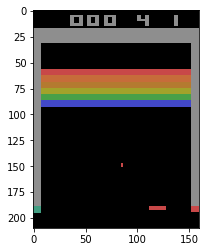

In [14]:
s,r,d,i = env.step(0)
plt.imshow(s)

In [23]:
print(s[190][115])

[200  72  72]
